# Modeling Pass The Pigs

After hours of playing this game at a house-warming party, and again playing it for class, I decided why not figure out a way I can be the best there ever was.

The information on how to play and what the game is can be found here:
https://en.wikipedia.org/wiki/Pass_the_Pigs.
Essentially this game is dice with pigs instead of dice.

## Strategy

* Get input data from my class
    * Look for probabilities of outcomes for each dice
    * Maybe look at distributions for outcomes of each dice roll
* Simulate
* ??



## Read the Data

First we read in the data from all teams in my class.

In [1]:
import pandas as pd

data = pd.read_csv("pass_the_pigs.csv")
data

,dot,dot_f,razorback,trotter,snouter,leaning_jowler,other
0,38,52,45,17,2,0,1
1,19,32,32,4,3,0,0
2,14,26,20,7,3,0,2
3,14,21,25,5,1,0,3
4,15,27,40,13,5,0,0
5,32,45,43,10,9,0,0
6,16,24,20,6,1,1,2
7,16,50,53,13,4,1,0
8,24,23,17,7,0,3,0
9,13,25,38,12,3,2,4


Even though the data looks a bit uneven, we find the percentage that each outcome was found as well as the standard deviation for each outcome for each class.

In [2]:
total_rolls = data.values.sum()

#keys for shorthand, I may want to actually type these out in future or just use a basic conversion
keys = {
    'dot' : 'dot',
    'dot_f' : 'nod',
    'razorback' : 'rzb',
    'trotter' : 'ttr',
    'snouter' : 'str',
    'leaning_jowler' : 'ljw',
    'other' : 'otr'
}

#find percentages for each row to calculate standard deviation
cols = list(keys.keys())
shortcut = list(keys.values())

pct_data = data
pct_data[cols] = data[cols].div(data[cols].sum(axis=1), axis=0)

pct_std = pd.DataFrame([pct_data[cols].std()])
total_pct = pd.DataFrame([pct_data[cols].mean()])

pct_std.rename(columns=keys, inplace='True')
total_pct.rename(columns=keys, inplace='True')

# input of relative frequencies from wikipedia
wiki_pct = pd.DataFrame.from_dict({
    'dot' : [.349],
    'nod' : [.302],
    'rzb' : [.224],
    'ttr' : [.088],
    'str' : [.030],
    'ljw' : [.0061],
    'otr' : [.0009]
})

In [3]:
#Standard Deviations of each proportion
pct_std

,dot,nod,rzb,ttr,str,ljw,otr
0,0.057471,0.03772,0.055139,0.026299,0.019023,0.013052,0.017999


In [4]:
#total proportions or the average proportion of values
total_pct

,dot,nod,rzb,ttr,str,ljw,otr
0,0.203947,0.32675,0.328447,0.089408,0.027842,0.007522,0.016084


https://en.wikipedia.org/wiki/Pass_the_Pigs#Relative_frequencies

In [5]:
#relative frequencies from Wikipedia 
wiki_pct

,dot,nod,rzb,ttr,str,ljw,otr
0,0.349,0.302,0.224,0.088,0.03,0.0061,0.0009


What we have now are sampling distributions of the proportions from a sample of size 14 in DataFrames.

## Strategies

A few possible strategies to look at (these may be updated):

    1) Roll until we hit 100
    2) Roll until we hit 20
    3) Roll until the EV is negative
    4) ...

## Expected Values

First, we take a look at the expected value for rolling two pigs with a given score. This is a combination of score and probability. This should also inform a possible strategy for simulation. https://en.wikipedia.org/wiki/Pass_the_Pigs#Scoring

In [6]:
def score(r1, r2, current_score=0):
    scores = {
        'dot' : 1,
        'nod' : 1,
        'rzb' : 5,
        'ttr' : 5,
        'str' : 10,
        'ljw' : 15,
        'otr' : 0
    }
    
    score = 0
    if r1 == r2:
        if r1 == 'dot' or r1 == 'nod':
            score = 1
        else:
            score = scores[r1] * 4
    else:
        if 'dot' in (r1+r2) and 'nod' in (r1+r2):
            score = -1 * current_score
        else:
            score = max(scores[r1], scores[r2])
    return score
            
def expected_value(pct,current_score=0):
    total_score = 0

    #treat this as a global -- maybe change for style later
    for c1 in shortcut:
        for c2 in shortcut:
            total_score += score(c1,c2,current_score) * (pct[c1][0] * pct[c2][0])
    return total_score

expected_value(total_pct, 0)
        


5.85151971969931

## Defining Strategies

1) Roll until we hit 100 (we win)

2) Roll until we hit an arbitrary number (stop_at_n)

In [9]:
def stop_at_n(current_score, n=20, pct=total_pct):
    return current_score >= n

3) Roll until expected value is zero or negative (not used)

In [8]:
def ev_strat(current_score, n=0, pct=total_pct):
    return expected_value(pct,current_score) > 0


In [7]:
cur = 0
while expected_value(total_pct,cur) > 0:
    cur +=1
print(f'rolls until EX = 0: {cur}')

rolls until EX = 0: 43


## Simulation

Let's make a simulation employing each strategy

In [10]:
import numpy as np

def simulation_run(strat, n=20, pct=total_pct, logs=False):
    #note-to-self strat.call()
    
    turns = 0 #let's count the number of turns it takes to reach 100
    
    total_score = 0
    
    # for scoring
    sim_pct = pct.cumsum(axis = 1)
    
    while total_score <= 100:
        turns += 1
        turn_score = 0
        while not strat(turn_score, n=n, pct=pct):
            #determine the rolls 
            [roll1, roll2] = ['','']
            #use a uniform distribution opposite of the cumulative sum s.t. we get a type of roll
            [rand1, rand2] = [np.random.uniform(), np.random.uniform()]
            for col in shortcut:
                if rand1 < sim_pct[col][0] and roll1 == '':
                    roll1 = col
                if rand2 < sim_pct[col][0] and roll2 == '':
                    roll2 = col
            current_score = score(roll1, roll2, turn_score)
            turn_score += current_score
            if current_score < 0:
                break
        if logs:
            print(f'turn: {turn_score}\t total:{total_score}')
        total_score += turn_score
        
    return turns



print(simulation_run(stop_at_n, logs=True))

turn: 0	 total:0
turn: 25	 total:0
turn: 0	 total:25
turn: 20	 total:25
turn: 20	 total:45
turn: 0	 total:65
turn: 0	 total:65
turn: 53	 total:65
8


In [11]:
def monte_carlo(m=100,strat=stop_at_n, n=20, pct=total_pct):
    results = []
    for i in range(0,m):
        results.append(simulation_run(strat,pct=pct, n=n))
    return results

Let's try the simulation for 1000 runs of the safe strategy

In [12]:
results = monte_carlo(m=1000, n=20)
results

[6,
 9,
 5,
 8,
 5,
 8,
 6,
 7,
 6,
 4,
 8,
 4,
 4,
 9,
 9,
 8,
 6,
 6,
 8,
 5,
 8,
 9,
 9,
 5,
 7,
 5,
 7,
 5,
 9,
 8,
 7,
 6,
 10,
 5,
 5,
 5,
 4,
 6,
 4,
 8,
 5,
 5,
 7,
 8,
 6,
 6,
 7,
 9,
 8,
 8,
 5,
 10,
 6,
 8,
 5,
 7,
 5,
 6,
 9,
 4,
 7,
 11,
 6,
 8,
 9,
 5,
 6,
 6,
 8,
 7,
 6,
 11,
 9,
 8,
 6,
 7,
 5,
 5,
 4,
 10,
 8,
 7,
 6,
 7,
 6,
 10,
 7,
 5,
 6,
 6,
 8,
 8,
 6,
 7,
 7,
 11,
 5,
 10,
 6,
 10,
 9,
 8,
 10,
 8,
 5,
 7,
 4,
 7,
 4,
 5,
 13,
 5,
 4,
 9,
 10,
 8,
 6,
 6,
 6,
 10,
 4,
 6,
 7,
 7,
 4,
 6,
 7,
 8,
 8,
 8,
 5,
 5,
 7,
 7,
 6,
 4,
 6,
 8,
 6,
 5,
 5,
 8,
 8,
 14,
 6,
 7,
 6,
 6,
 8,
 7,
 8,
 8,
 8,
 6,
 8,
 7,
 5,
 8,
 8,
 6,
 6,
 5,
 6,
 5,
 10,
 9,
 7,
 9,
 5,
 7,
 6,
 8,
 10,
 5,
 7,
 6,
 6,
 8,
 7,
 7,
 9,
 9,
 6,
 8,
 8,
 8,
 6,
 9,
 10,
 6,
 6,
 5,
 6,
 5,
 8,
 8,
 5,
 6,
 9,
 6,
 6,
 5,
 6,
 6,
 8,
 8,
 9,
 7,
 10,
 5,
 8,
 7,
 5,
 8,
 5,
 8,
 8,
 5,
 4,
 6,
 6,
 9,
 8,
 5,
 6,
 5,
 6,
 9,
 7,
 6,
 6,
 5,
 7,
 8,
 6,
 6,
 8,
 5,
 7,
 5,
 6,
 5,
 6,
 7,
 7,
 4

In [13]:
import matplotlib.pyplot as plt
plt.hist(results,density = True, bins= 10)
plt.xlabel('# of turns')
plt.ylabel('Probability')
plt.title('Histogram of turns taken to win with strategy of stopping @ 20 points')
plt.show()

<Figure size 640x480 with 1 Axes>

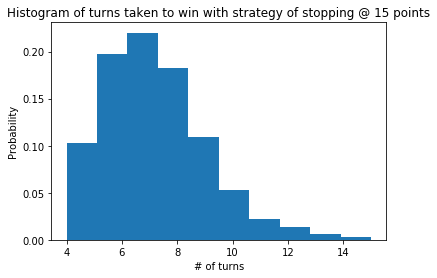

In [14]:
results = monte_carlo(m=1000,strat=stop_at_n, n=15)

plt.hist(results, density = True, bins= 10)
plt.xlabel('# of turns')
plt.ylabel('Probability')
plt.title('Histogram of turns taken to win with strategy of stopping @ 15 points')
plt.show()

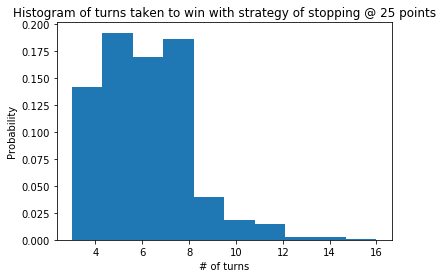

In [15]:
results = monte_carlo(m=1000,strat=stop_at_n,n=25)

plt.hist(results, density =True, bins= 10)
plt.xlabel('# of turns')
plt.ylabel('Probability')
plt.title('Histogram of turns taken to win with strategy of stopping @ 25 points')
plt.show()

In [24]:
avg_turns = []
std_turns = []

rng = range(15,30)

for i in rng:
    print(f'calcuating {i}...')
    cur_results = monte_carlo(m=500,strat=stop_at_n,n=i)
    cur_mean = np.mean(cur_results)
    cur_std = np.std(cur_results)
    avg_turns.append(cur_mean)
    std_turns.append(cur_std)
    print(f'mean of {i}: {cur_mean}\n')
    
avg_turns

calcuating 15...
mean of 15: 7.294

calcuating 16...
mean of 16: 7.032

calcuating 17...
mean of 17: 6.85

calcuating 18...
mean of 18: 6.752

calcuating 19...
mean of 19: 6.77

calcuating 20...
mean of 20: 6.782

calcuating 21...
mean of 21: 6.46

calcuating 22...
mean of 22: 6.334

calcuating 23...
mean of 23: 6.352

calcuating 24...
mean of 24: 6.27

calcuating 25...
mean of 25: 6.082

calcuating 26...
mean of 26: 6.194

calcuating 27...
mean of 27: 6.178

calcuating 28...
mean of 28: 6.162

calcuating 29...
mean of 29: 6.072



[7.294,
 7.032,
 6.85,
 6.752,
 6.77,
 6.782,
 6.46,
 6.334,
 6.352,
 6.27,
 6.082,
 6.194,
 6.178,
 6.162,
 6.072]

Text(0.5, 0, 'score to stop at')

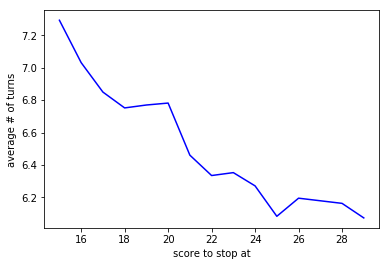

In [25]:
plt.plot(rng,avg_turns, color ='blue')

plt.ylabel('average # of turns')
plt.xlabel('score to stop at')

Text(0.5, 0, 'score to stop at')

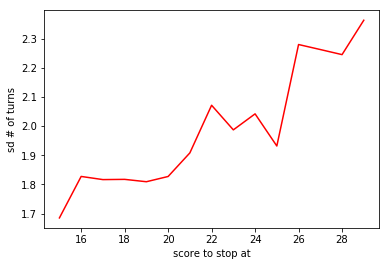

In [26]:
plt.plot(rng,std_turns, color ='red')

plt.ylabel('sd # of turns')
plt.xlabel('score to stop at')

In [19]:
avg_turns = []
std_turns = []

rng = range(25,45)

for i in rng:
    print(f'calcuating {i}...')
    cur_results = monte_carlo(m=500,strat=stop_at_n,n=i)
    cur_mean = np.mean(cur_results)
    cur_std = np.std(cur_results)
    avg_turns.append(cur_mean)
    std_turns.append(cur_std)
    print(f'mean of {i}: {cur_mean}\n')
    
avg_turns

calcuating 25...
mean of 25: 6.132

calcuating 26...
mean of 26: 6.01

calcuating 27...
mean of 27: 6.032

calcuating 28...
mean of 28: 5.85

calcuating 29...
mean of 29: 6.18

calcuating 30...
mean of 30: 5.966

calcuating 31...
mean of 31: 5.776

calcuating 32...
mean of 32: 5.652

calcuating 33...
mean of 33: 5.764

calcuating 34...
mean of 34: 5.69

calcuating 35...
mean of 35: 5.938

calcuating 36...
mean of 36: 6.114

calcuating 37...
mean of 37: 6.16

calcuating 38...
mean of 38: 6.312

calcuating 39...
mean of 39: 6.38

calcuating 40...
mean of 40: 6.38

calcuating 41...
mean of 41: 6.484

calcuating 42...
mean of 42: 6.356

calcuating 43...
mean of 43: 6.504

calcuating 44...
mean of 44: 6.068



[6.132,
 6.01,
 6.032,
 5.85,
 6.18,
 5.966,
 5.776,
 5.652,
 5.764,
 5.69,
 5.938,
 6.114,
 6.16,
 6.312,
 6.38,
 6.38,
 6.484,
 6.356,
 6.504,
 6.068]

Text(0.5, 0, 'score to stop at')

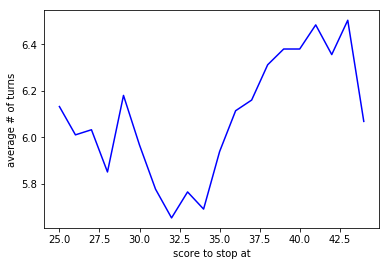

In [23]:
plt.plot(rng,avg_turns, color = 'blue')
plt.ylabel('average # of turns')
plt.xlabel('score to stop at')

Text(0.5, 0, 'score to stop at')

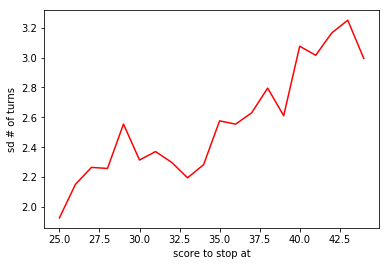

In [22]:
plt.plot(rng,std_turns, color = 'red')
plt.ylabel('sd # of turns')
plt.xlabel('score to stop at')